In [2]:
import tensorflow as tf
print(f"Num Gpu Avaiable Are : {len(tf.config.list_physical_devices('GPU'))}")

Num Gpu Avaiable Are : 1


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
import cv2
import os, glob
import tensorflow as tf
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D,GlobalAveragePooling2D,Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)


In [4]:
data_train = r"./Dataset/train"
data_test = r"./Dataset/test"
fake=[]
for file in os.listdir(data_test):
    if file[0] =='.':
        continue
    fake+=[file]
print(fake)
print(len(fake))
# for file1 in os.listdir(data_train):
#     if file1[0] =='.':
#         continue
#     fake+=[file1]
# print(fake)
# print(len(fake))

['Benign', 'Malignant early Pre-B', 'Malignant Pre-B', 'Malignant Pro-B']
4


In [5]:
img_height,img_width=256,256
batch_size=20

train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(data_train,
                                                target_size=(img_height,img_width),
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                               )
test_generator = train_datagen.flow_from_directory(data_test,
                                                target_size=(img_height,img_width),
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                               )

Found 3242 images belonging to 4 classes.
Found 1852 images belonging to 4 classes.


In [6]:
precision=tf.keras.metrics.Precision()
recall=tf.keras.metrics.Recall()
sensitivity=tf.keras.metrics.SensitivityAtSpecificity(0.1)
specificity=tf.keras.metrics.SpecificityAtSensitivity(0.1)

In [7]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data vb and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

## CNN

In [8]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (img_height,img_width,3)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))

model.add(Dense(4, activation = "softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 32)      25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 262144)            0

In [9]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=['accuracy',precision,recall,sensitivity,specificity])
hist=model.fit(train_generator,epochs=50,validation_data=test_generator)


Epoch 1/50
163/163 [==============================] - 145s 840ms/step - loss: 1.5886 - accuracy: 0.4402 - precision: 0.5175 - recall: 0.1456 - sensitivity_at_specificity: 0.9735 - specificity_at_sensitivity: 0.9680 - val_loss: 1.0741 - val_accuracy: 0.6647 - val_precision: 0.7837 - val_recall: 0.1037 - val_sensitivity_at_specificity: 0.9995 - val_specificity_at_sensitivity: 0.9921
Epoch 2/50
163/163 [==============================] - 92s 564ms/step - loss: 0.6967 - accuracy: 0.7088 - precision: 0.7519 - recall: 0.6385 - sensitivity_at_specificity: 1.0000 - specificity_at_sensitivity: 0.9985 - val_loss: 1.0114 - val_accuracy: 0.6533 - val_precision: 0.6828 - val_recall: 0.4487 - val_sensitivity_at_specificity: 1.0000 - val_specificity_at_sensitivity: 0.9982
Epoch 3/50
163/163 [==============================] - 96s 587ms/step - loss: 0.5679 - accuracy: 0.7656 - precision: 0.7855 - recall: 0.7366 - sensitivity_at_specificity: 0.9997 - specificity_at_sensitivity: 0.9998 - val_loss: 0.4607 

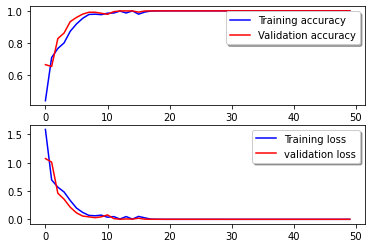

In [10]:
fig, ax = plt.subplots(2,1)
ax[0].plot(hist.history['accuracy'], color='b', label="Training accuracy")
ax[0].plot(hist.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist.history['loss'], color='b', label="Training loss")
ax[1].plot(hist.history['val_loss'], color='r', label="validation loss")
legend = ax[1].legend(loc='best', shadow=True)

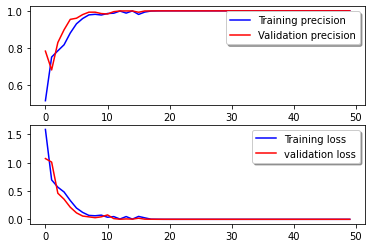

In [11]:
fig, ax = plt.subplots(2,1)
ax[0].plot(hist.history['precision'], color='b', label="Training precision")
ax[0].plot(hist.history['val_precision'], color='r',label="Validation precision")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist.history['loss'], color='b', label="Training loss")
ax[1].plot(hist.history['val_loss'], color='r', label="validation loss")
legend = ax[1].legend(loc='best', shadow=True)

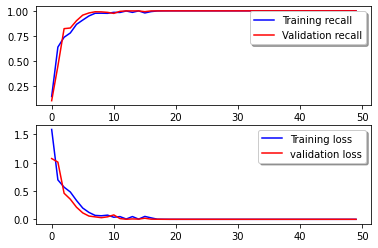

In [12]:
fig, ax = plt.subplots(2,1)
ax[0].plot(hist.history['recall'], color='b', label="Training recall")
ax[0].plot(hist.history['val_recall'], color='r',label="Validation recall")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist.history['loss'], color='b', label="Training loss")
ax[1].plot(hist.history['val_loss'], color='r', label="validation loss")
legend = ax[1].legend(loc='best', shadow=True)

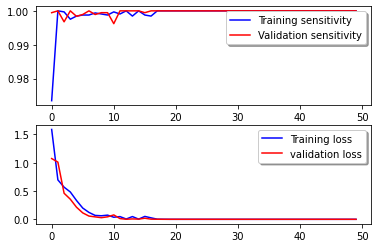

In [13]:
fig, ax = plt.subplots(2,1)
ax[0].plot(hist.history['sensitivity_at_specificity'], color='b', label="Training sensitivity")
ax[0].plot(hist.history['val_sensitivity_at_specificity'], color='r',label="Validation sensitivity")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist.history['loss'], color='b', label="Training loss")
ax[1].plot(hist.history['val_loss'], color='r', label="validation loss")
legend = ax[1].legend(loc='best', shadow=True)

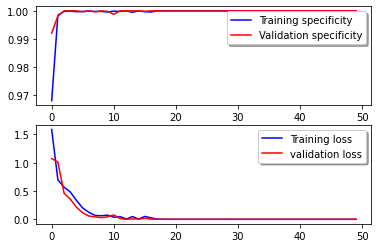

In [14]:
fig, ax = plt.subplots(2,1)
ax[0].plot(hist.history['specificity_at_sensitivity'], color='b', label="Training specificity")
ax[0].plot(hist.history['val_specificity_at_sensitivity'], color='r',label="Validation specificity")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist.history['loss'], color='b', label="Training loss")
ax[1].plot(hist.history['val_loss'], color='r', label="validation loss")
legend = ax[1].legend(loc='best', shadow=True)

In [15]:
model.save("./models/CNN.h5")

In [16]:
filenames = test_generator.filenames
nb_samples = len(filenames)
model_predict = model.predict_generator(test_generator,steps = nb_samples, verbose=2)

c:\Users\0258\.conda\envs\deepfake\lib\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


1852/1852 - 35s


Confusion matrix, without normalization
[[ 34  63  65  74]
 [ 61 188 151 147]
 [ 67 135 127 158]
 [ 74 161 144 203]]


<AxesSubplot:title={'center':'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

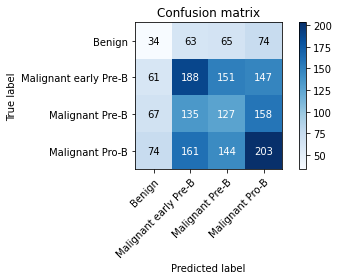

In [18]:
y_true = test_generator.classes
y_pred = model_predict.argmax(axis=1)
plot_confusion_matrix(y_true, y_pred, classes=['Benign', 'Malignant early Pre-B','Malignant Pre-B','Malignant Pro-B'],
                      title='Confusion matrix')

## MOBILENET

In [19]:
base_model = tf.keras.applications.MobileNet(input_shape=(img_height,img_width, 3), include_top=False,
                          weights='imagenet')
model8 = Sequential()
model8.add(base_model)
model8.add(GlobalAveragePooling2D())
model8.add(Dense(64, activation='relu'))
model8.add(BatchNormalization())
model8.add(Dropout(0.2))
model8.add(Dense(4, activation='sigmoid'))
model8.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 8, 8, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                65600     
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 260       
Total params: 3,294,980
Trainable params: 3,272,964
Non-trainable params: 22,016
_______________________________________

In [20]:
model8.compile(optimizer="adam",loss="categorical_crossentropy",metrics=['accuracy',precision,recall,sensitivity,specificity])
hist8=model8.fit(train_generator,epochs=50,validation_data=test_generator)
model8.save("./models/mobilenet.h5")


Epoch 1/50
163/163 [==============================] - 94s 554ms/step - loss: 0.1481 - accuracy: 0.9488 - precision: 0.7789 - recall: 0.9923 - sensitivity_at_specificity: 1.0000 - specificity_at_sensitivity: 0.9996 - val_loss: 0.7983 - val_accuracy: 0.6145 - val_precision: 0.4283 - val_recall: 0.9276 - val_sensitivity_at_specificity: 1.0000 - val_specificity_at_sensitivity: 0.9998
Epoch 2/50
163/163 [==============================] - 92s 565ms/step - loss: 0.0948 - accuracy: 0.9688 - precision: 0.7370 - recall: 0.9948 - sensitivity_at_specificity: 1.0000 - specificity_at_sensitivity: 0.9997 - val_loss: 0.3361 - val_accuracy: 0.8828 - val_precision: 0.6978 - val_recall: 0.9989 - val_sensitivity_at_specificity: 1.0000 - val_specificity_at_sensitivity: 0.9840
Epoch 3/50
163/163 [==============================] - 96s 589ms/step - loss: 0.0407 - accuracy: 0.9867 - precision: 0.7686 - recall: 0.9991 - sensitivity_at_specificity: 1.0000 - specificity_at_sensitivity: 0.9998 - val_loss: 0.0025 -

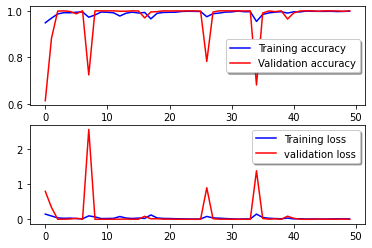

In [21]:
fig, ax = plt.subplots(2,1)
ax[0].plot(hist8.history['accuracy'], color='b', label="Training accuracy")
ax[0].plot(hist8.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist8.history['loss'], color='b', label="Training loss")
ax[1].plot(hist8.history['val_loss'], color='r', label="validation loss",axes =ax[1])
legend = ax[1].legend(loc='best', shadow=True)

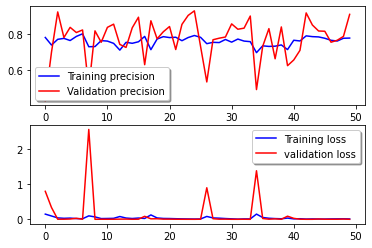

In [22]:
fig, ax = plt.subplots(2,1)
ax[0].plot(hist8.history['precision'], color='b', label="Training precision")
ax[0].plot(hist8.history['val_precision'], color='r',label="Validation precision")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist8.history['loss'], color='b', label="Training loss")
ax[1].plot(hist8.history['val_loss'], color='r', label="validation loss",axes =ax[1])
legend = ax[1].legend(loc='best', shadow=True)

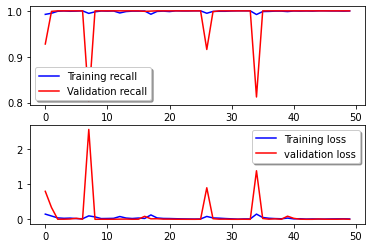

In [23]:
fig, ax = plt.subplots(2,1)
ax[0].plot(hist8.history['recall'], color='b', label="Training recall")
ax[0].plot(hist8.history['val_recall'], color='r',label="Validation recall")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist8.history['loss'], color='b', label="Training loss")
ax[1].plot(hist8.history['val_loss'], color='r', label="validation loss",axes =ax[1])
legend = ax[1].legend(loc='best', shadow=True)

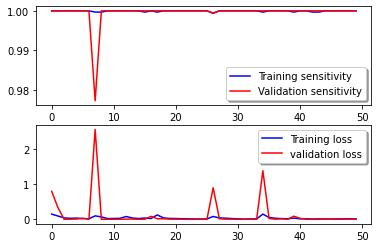

In [24]:
fig, ax = plt.subplots(2,1)
ax[0].plot(hist8.history['sensitivity_at_specificity'], color='b', label="Training sensitivity")
ax[0].plot(hist8.history['val_sensitivity_at_specificity'], color='r',label="Validation sensitivity")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist8.history['loss'], color='b', label="Training loss")
ax[1].plot(hist8.history['val_loss'], color='r', label="validation loss",axes =ax[1])
legend = ax[1].legend(loc='best', shadow=True)

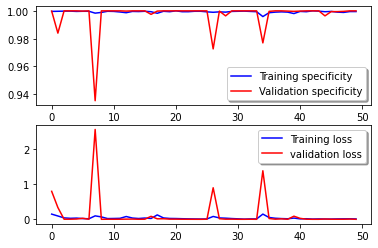

In [25]:
fig, ax = plt.subplots(2,1)
ax[0].plot(hist8.history['specificity_at_sensitivity'], color='b', label="Training specificity")
ax[0].plot(hist8.history['val_specificity_at_sensitivity'], color='r',label="Validation specificity")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist8.history['loss'], color='b', label="Training loss")
ax[1].plot(hist8.history['val_loss'], color='r', label="validation loss",axes =ax[1])
legend = ax[1].legend(loc='best', shadow=True)

In [26]:
filenames = test_generator.filenames
nb_samples = len(filenames)
model1_predict = model8.predict_generator(test_generator,steps = nb_samples, verbose=2)

c:\Users\0258\.conda\envs\deepfake\lib\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


1852/1852 - 35s


Confusion matrix, without normalization
[[ 29  63  55  89]
 [ 68 169 140 170]
 [ 63 136 120 168]
 [ 76 179 172 155]]


<AxesSubplot:title={'center':'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

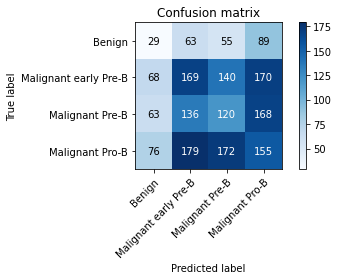

In [27]:
y_true = test_generator.classes
y_pred = model1_predict.argmax(axis=1)
plot_confusion_matrix(y_true, y_pred, classes=['Benign', 'Malignant early Pre-B','Malignant Pre-B','Malignant Pro-B'],
                      title='Confusion matrix')